# Description of the final project

## Introduction

This project is devoted to the question-answering task. You are going to work with the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no. 

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "answer": false,
      "title": "Time in France",
    }

For this project you will need only `train` and `val` parts.

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044

## Bonus for those, who want to work with Russian

For those who want to work with Russian data there is an option to use **DaNetQA** dataset (instead of BoolQ) from Russsian SuperGLUE. The dataset is organised similarly to BoolQ.

You may download data from here: https://russiansuperglue.com/tasks/download/DaNetQA

Detailed task description is available here: https://arxiv.org/abs/2010.02605


**Note:** note that you should take only one dataset (either BoolQ or DanetQA). There are no bonus points for solving both tasks.


## Detailed Task Description

In the task you should perform all the model training on `train.jsonl` data and evaluate your models on `val.jsonl`. Note that you do not need `test.jsonl`.

Use **accuracy metric** for scoring.

The solution of either BoolQ or DaNetQA should include:


### [10%] 1. Data analysis 


* 1.1  (10%) Download the data and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pylab

import nltk
import string
import os
import random
nltk.download('punkt')
import torch
from collections import defaultdict
from collections import Counter
from sklearn.svm import SVC
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train = pd.read_json('/content/drive/MyDrive/NLP_final/DaNetQA/train.jsonl', lines=True)
del train['idx']
val = pd.read_json('/content/drive/MyDrive/NLP_final/DaNetQA/val.jsonl', lines=True)
del val['idx']

In [ ]:
train.head()

,question,passage,label
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False


In [ ]:
val.head()

,question,passage,label
0,Есть ли вода на марсе?,Гидросфера Марса — это совокупность водных зап...,True
1,Состоит ли англия в евросоюзе?,В полночь с 31 января на 1 февраля 2020 года п...,False
2,Действительно ли в ссср не было адвокатов?,Семён Львович Ария — советский и российский ю...,False
3,Была ли чума в оране?,"Чума — это и абсурд, что осмысливается как фор...",True
4,Был ли кетчуп в читосе?,Текущий каталог продукции размещен на сайте пр...,True


Class distribution :

validation data is more balanced 

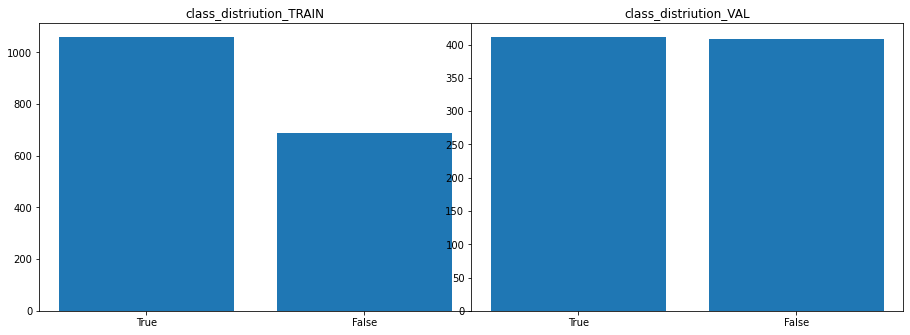

In [ ]:
fig = plt.figure()
ax = fig.add_axes([1, 1, 1, 1])
dataset = train['label'].value_counts()
ax.bar(['True', 'False'], dataset)
ax.title.set_text('class_distriution_TRAIN')

ax = fig.add_axes([2, 1, 1, 1])
dataset = val['label'].value_counts()
ax.bar(['True', 'False'], dataset)
ax.title.set_text('class_distriution_VAL')
plt.show()

Mean sentence length :

In [ ]:
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(['«', '»', '—', '–', '...', "''", 'это'])

#Preprocess function
def preprocess(text):

    tokens = word_tokenize(text.lower())
    tokens = [i for i in tokens if (i not in string.punctuation)]
    tokens = [token for token in tokens if token not in russian_stopwords]
    
    return tokens

def preprocess_text(text):
    sent = [preprocess(sent) for sent in sent_tokenize(text)]
    return sent

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from statistics import mean, median

train['tok_question'] = train['question'].apply(lambda x: preprocess_text(x))
train['tok_passage'] = train['passage'].apply(lambda x: preprocess_text(x))

train['question_sents'] = train['tok_question'].apply(lambda x: len(x))
train['question_words_mean'] = train['tok_question'].apply(lambda x: mean([len(i) for i in x]))

train['passage_sents'] = train['tok_passage'].apply(lambda x: len(x))
train['passage_words_mean'] = train['tok_passage'].apply(lambda x: mean([len(i) for i in x]))

In [ ]:
train.head()

,question,passage,label,tok_question,tok_passage,question_sents,question_words_mean,passage_sents,passage_words_mean
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,"[[вднх, выставочный, центр]]","[[вы́ставочный, центр, станция, московского, м...",1,3.0,6,8.333333
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,"[[вднх, выставочный, центр]]","[[вы́ставка, достиже́ний, наро́дного, хозя́йст...",1,3.0,6,16.500000
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,"[[джиган, black, star]]","[[вместе, этим, треком, выступили, церемонии, ...",1,3.0,5,12.600000
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,"[[xiaomi, конкурент, apple]]","[[xiaomi, китайская, компания, основанная, 201...",1,3.0,6,13.666667
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,"[[автомат, калашникова, вов]]","[[отметив, некоторые, недостатки, целом, удачн...",1,3.0,5,13.600000


In [ ]:
#function for list converting

def f(_list_):
  new_list = []
  for el in (_list_):
    for _ in el:
      new_list.append(_)
  return new_list

In [ ]:
#converting token columns to single-level lists

train['tok_question_words'] = train['tok_question'].apply(lambda x: f(x))
train['tok_passage_words'] = train['tok_passage'].apply(lambda x: f(x))
train['question_words_unique'] = train['tok_question_words'].apply(lambda x: len(set(x)))
train['passage_words_unique'] = train['tok_passage_words'].apply(lambda x: len(set(x)))

In [ ]:
train.describe()

,question_sents,question_words_mean,passage_sents,passage_words_mean,question_words_unique,passage_words_unique
count,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000
mean,1.001715,3.985706,5.485992,14.323299,3.977130,65.077759
std,0.041392,2.221970,2.531823,6.712462,2.184704,23.653092
min,1.000000,1.000000,1.000000,5.047619,1.000000,26.000000
25%,1.000000,3.000000,5.000000,10.800000,3.000000,50.000000
50%,1.000000,3.000000,5.000000,13.200000,3.000000,60.000000
75%,1.000000,5.000000,5.000000,16.200000,5.000000,74.000000
max,2.000000,21.000000,22.000000,103.000000,21.000000,297.000000


In [ ]:
num_col = ['question_sents',	'question_words_mean',	'passage_sents',	'passage_words_mean']

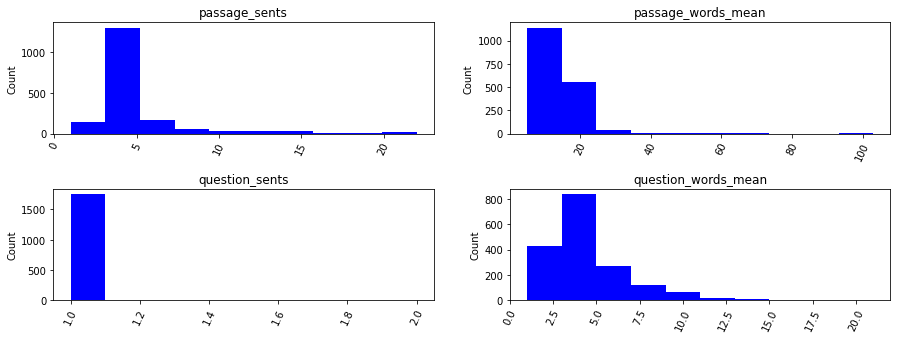

In [ ]:
### TRAIN numerical features

plt.subplots(nrows=1, ncols=2, figsize=(15, 45))
plt.subplots_adjust(hspace=.5)

for num, axs in zip(sorted(num_col), [[1], [2], [3], [4]]):
    
    ax = plt.subplot(15, 2, axs[0])
    
    ax.hist(train[num], color='b')

    ax.title.set_text(num)
    ax.set_ylabel('Count')
    plt.xticks(rotation=65)

In [ ]:
val['tok_question'] = val['question'].apply(lambda x: preprocess_text(x))
val['tok_passage'] = val['passage'].apply(lambda x: preprocess_text(x))

val['question_sents'] = val['tok_question'].apply(lambda x: len(x))
val['question_words_mean'] = val['tok_question'].apply(lambda x: mean([len(i) for i in x]))

val['passage_sents'] = val['tok_passage'].apply(lambda x: len(x))
val['passage_words_mean'] = val['tok_passage'].apply(lambda x: mean([len(i) for i in x]))

In [ ]:
val.head()

,question,passage,label,tok_question,tok_passage,question_sents,question_words_mean,passage_sents,passage_words_mean
0,Есть ли вода на марсе?,Гидросфера Марса — это совокупность водных зап...,True,"[[вода, марсе]]","[[гидросфера, марса, совокупность, водных, зап...",1,2,5,22.6
1,Состоит ли англия в евросоюзе?,В полночь с 31 января на 1 февраля 2020 года п...,False,"[[состоит, англия, евросоюзе]]","[[полночь, 31, января, 1, февраля, 2020, года,...",1,3,5,22.4
2,Действительно ли в ссср не было адвокатов?,Семён Львович Ария — советский и российский ю...,False,"[[действительно, ссср, адвокатов]]","[[семён, львович, ария, советский, российский,...",1,3,5,13.8
3,Была ли чума в оране?,"Чума — это и абсурд, что осмысливается как фор...",True,"[[чума, оране]]","[[чума, абсурд, осмысливается, форма, существо...",1,2,5,13.2
4,Был ли кетчуп в читосе?,Текущий каталог продукции размещен на сайте пр...,True,"[[кетчуп, читосе]]","[[текущий, каталог, продукции, размещен, сайте...",1,2,2,59.0


In [ ]:
val['tok_question_words'] = val['tok_question'].apply(lambda x: f(x))
val['tok_passage_words'] = val['tok_passage'].apply(lambda x: f(x))
val['question_words_unique'] = val['tok_question_words'].apply(lambda x: len(set(x)))
val['passage_words_unique'] = val['tok_passage_words'].apply(lambda x: len(set(x)))

In [ ]:
val.describe()

,question_sents,question_words_mean,passage_sents,passage_words_mean,question_words_unique,passage_words_unique
count,821.0,821.000000,821.000000,821.000000,821.000000,821.000000
mean,1.0,3.158343,5.012180,13.777121,3.158343,61.746650
std,0.0,1.136649,0.220527,4.067811,1.136649,16.186388
min,1.0,1.000000,2.000000,5.800000,1.000000,26.000000
25%,1.0,2.000000,5.000000,11.000000,2.000000,50.000000
50%,1.0,3.000000,5.000000,13.200000,3.000000,60.000000
75%,1.0,4.000000,5.000000,16.000000,4.000000,72.000000
max,1.0,9.000000,6.000000,59.000000,9.000000,120.000000


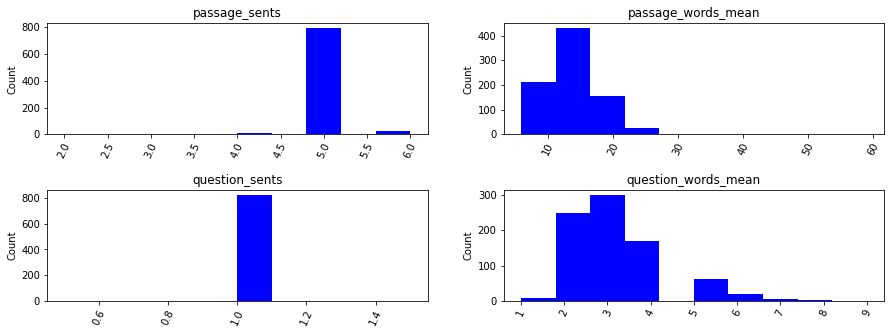

In [ ]:
### VAL numerical features

plt.subplots(nrows=1, ncols=2, figsize=(15, 45))
plt.subplots_adjust(hspace=.5)

for num, axs in zip(sorted(num_col), [[1], [2], [3], [4]]):
    
    ax = plt.subplot(15, 2, axs[0])
    
    ax.hist(val[num], color='b')

    ax.title.set_text(num)
    ax.set_ylabel('Count')
    plt.xticks(rotation=65)

In [ ]:
ttq = []
for i in train['tok_question']:
    for j in i:
      for _ in j:
        ttq.append(_)
vtq = []
for i in val['tok_question']:
    for j in i:
      for _ in j:
        vtq.append(_)

In [ ]:
print('most frequent words in TRAIN question :', dict(Counter(ttq).most_common(10)))
print('most frequent words in VAL question :', dict(Counter(vtq).most_common(10)))

most frequent words in TRAIN question : {'входит': 89, 'едят': 48, 'правда': 37, 'россии': 37, 'ссср': 34, 'является': 32, 'разрешено': 32, 'передается': 27, 'бывает': 26, 'самом': 26}
most frequent words in VAL question : {'правда': 150, 'входит': 42, 'россии': 32, 'ссср': 31, 'едят': 23, 'разрешено': 19, 'состоит': 18, 'передается': 16, 'вредна': 15, 'войны': 13}


In [ ]:
ttp = []
for i in train['tok_passage']:
    for j in i:
      for _ in j:
        ttp.append(_)
vtp = []
for i in val['tok_passage']:
    for j in i:
      for _ in j:
        vtp.append(_)

In [ ]:
print('most frequent words in TRAIN passage :', dict(Counter(ttp).most_common(10)))
print('most frequent words in VAL passage :', dict(Counter(vtp).most_common(10)))

most frequent words in TRAIN passage : {'года': 787, 'году': 486, 'также': 480, 'время': 378, 'является': 349, 'однако': 250, 'её': 237, 'россии': 190, 'который': 178, 'лет': 177}
most frequent words in VAL passage : {'года': 473, 'году': 318, 'также': 254, 'время': 157, 'является': 131, 'лет': 119, 'её': 117, 'россии': 113, 'ссср': 96, 'века': 91}


In [ ]:
print('length of dictionary : ', len(set(ttq + vtq + ttp + vtp)))

length of dictionary :  53654


##Conclusion: 

TRAIN and VAL are similar in the most frequently used words and statistics such as the average number of words in questions and passages. 

But differ in class balance: 

61% TRUE / 39% FALSE in TRAN

vs 

50% TRUE / 50% FALSE in VAL

### [40%] 2. Pretrained embeddings as features for classifier
* 2.1 (5%) Take pre-trained word2vec or fastText embeddings and vectorize your data using them.

**Note:** you may use any pre-trained embeddings available on the Internet. For example, for English you may take GoogleNews vectors, which are available here: https://www.kaggle.com/leadbest/googlenewsvectorsnegative300 . For the Russian language you may choose one of the models from RusVectores (https://rusvectores.org/ru/models/).

* 2.2  (15%) Use pretrained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).

* 2.3 (5%) Instead of word2vec or fastText embeddings get BERT embeddings from the train dataset and vectorize your data. 

**Note:** you may use any of the BERT-like models from hugging face (https://huggingface.co/) library. For example, you may use `bert-base-multilingual-cased` (https://huggingface.co/bert-base-multilingual-cased).

* 2.4  (15%) Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).



###2.1-2.2

According to Paper ‘https://arxiv.org/pdf/2010.02605.pdf’ for training the Baseline we need  concatenated vectors of questions and paragraphs

In [ ]:
#loading word2vec model 

!wget -P /content/drive/MyDrive/NLP_final/model http://vectors.nlpl.eu/repository/20/220.zip
!unzip /content/drive/MyDrive/NLP_final/model/220.zip -d /content/drive/MyDrive/NLP_final/model

In [ ]:
from gensim import models

#ruwikiruscorpora_upos_cbow_300_10_2021
#http://vectors.nlpl.eu/repository/20/220.zip

model_path = '/content/drive/MyDrive/NLP_final/model/model.bin'
wv = models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
#loading libraries for tagging Russian words

!python -m spacy download ru_core_news_sm

2022-11-17 21:19:17.927137: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 1.7 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 8.2 MB 9.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=ae12774bd757756d3ed506e8ee7af8fee89b56af92f97c8adabac808708a78a5
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
import spacy
nlp = spacy.load('ru_core_news_sm')  
included_tags = {"NOUN", "VERB", "ADJ"}

In [ ]:
def ru_tags(X): 
  new_sentences = []
  for sentence in X:
      new_sentence = []
      for token in nlp(sentence):
          if token.pos_ in included_tags:
              new_sentence.append(token.text.lower()+'_'+token.pos_)
              print(new_sentence[0])
      new_sentences.append(new_sentence)
  return new_sentences

In [ ]:
#tagging russian words for further work with word2vec

train['question_ru_tags'] = train['tok_question_words'].apply(lambda x: ru_tags(x))
train['question_ru_tags'] = train['question_ru_tags'].apply(lambda x: f(x))

train['passage_ru_tags'] = train['tok_passage_words'].apply(lambda x: ru_tags(x))
train['passage_ru_tags'] = train['passage_ru_tags'].apply(lambda x: f(x)) 

val['question_ru_tags'] = val['tok_question_words'].apply(lambda x: ru_tags(x))
val['question_ru_tags'] = val['question_ru_tags'].apply(lambda x: f(x)) 

val['passage_ru_tags'] = val['tok_passage_words'].apply(lambda x: ru_tags(x))
val['passage_ru_tags'] = val['passage_ru_tags'].apply(lambda x: f(x)) 

In [ ]:
train['question_ru_tags'][1]

['вднх_NOUN', 'выставочный_ADJ', 'центр_NOUN']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = word2vec.vector_size 

    def fit(self, X, y):
        return self

    def transform(self, X):
        
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
vectorizer = MeanEmbeddingVectorizer(wv)

In [ ]:
#converting target feature to 1/0

train['target'] = train['label'].astype(int)
val['target'] = val['label'].astype(int)

In [ ]:
X_train = vectorizer.transform(train.question_ru_tags) + vectorizer.transform(train.passage_ru_tags)
X_test = vectorizer.transform(val.question_ru_tags) + vectorizer.transform(val.passage_ru_tags)

In [ ]:
etc = ExtraTreesClassifier(n_estimators=25, random_state=40, max_depth=25)
etc.fit(X_train, train.target)
y_pred = etc.predict(X_test)

acc_etc_wv = accuracy_score(val.target, y_pred)
acc_etc_wv

0.6163215590742996

In [ ]:
rf = RandomForestClassifier(n_estimators=25, random_state=40, max_depth=25)
rf.fit(X_train, train.target)
y_pred = rf.predict(X_test)

acc_rf_wv = accuracy_score(val.target, y_pred)
acc_rf_wv

0.5785627283800243

In [ ]:
svc = SVC(C=6.0, kernel='linear', class_weight='balanced')
svc.fit(X_train, train.target)
y_pred = svc.predict(X_test)

acc_svc_wv = accuracy_score(val.target, y_pred)
acc_svc_wv

0.5895249695493301

In [ ]:
df_1 = pd.DataFrame(np.array([acc_etc_wv, acc_rf_wv, acc_svc_wv]), index=['ExtraTreesClassifier', 'RandomForestClassifier', 'SVC'], columns=['accuracy_W2V_emb'])
df_1

,accuracy_W2V_emb
ExtraTreesClassifier,0.616322
RandomForestClassifier,0.578563
SVC,0.589525


###2.3-2.4

In [ ]:
!pip install transformers
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 70.8 MB/s 
     |████████████████████████████████| 182 kB 88.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt', do_lower_case=True)
output = model(**encoded_input)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Keyword arguments {'do_lower_case': True} not recognized.


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
device = torch.device("cpu")

In [ ]:
# as pattern was used bert_sklearn_transformer from https://gist.github.com/nbertagnolli/e10d26b435a242efa33e511af21bd400 

from sklearn.base import TransformerMixin, BaseEstimator
from typing import Callable, List, Optional, Tuple

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, question: str, passage: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        encoded_data = self.tokenizer.encode_plus(question, 
                                                  passage,
                                                  add_special_tokens=True,
                                                  max_length=self.max_length
                                                  )
        
        encoded_pair = encoded_data['input_ids']
        
        # Create an attention mask telling BERT to use all words
        attention_mask = encoded_data['attention_mask']

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(encoded_pair).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, question: str, passage: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(question, passage)
        embeddings = self.model(tokenized, attention_mask)
        
        return self.embedding_func(embeddings)

    def transform(self, data: tuple):
        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(question, passage) for question, passage in data])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [ ]:
X_train = zip(list(train['question']), list(train['passage']))
X_test = zip(list(val['question']), list(val['passage']))

In [ ]:
transformer = BertTransformer(tokenizer, model)
etc = ExtraTreesClassifier(class_weight='balanced')

model_etc = Pipeline(
    [("embeddings", transformer),
     ("classifier", etc)])

model_etc.fit(X_train, train.target)
y_pred = model_etc.predict(X_test)

In [ ]:
acc_etc_bert = accuracy_score(val.target, y_pred)
acc_etc_bert

0.535931790499391

In [ ]:
X_train = zip(list(train['question']), list(train['passage']))
X_test = zip(list(val['question']), list(val['passage']))

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')

model_rf = Pipeline(
    [("embeddings", transformer),
     ("classifier", rf)])

model_rf.fit(X_train, train.target)
y_pred = model_rf.predict(X_test)

In [ ]:
acc_rf_bert = accuracy_score(val.target, y_pred)
acc_rf_bert

0.5200974421437271

In [ ]:
X_train = zip(list(train['question']), list(train['passage']))
X_test = zip(list(val['question']), list(val['passage']))

In [ ]:
svc = SVC(kernel='linear', class_weight='balanced')

model_svc = Pipeline(
    [("embeddings", transformer),
     ("classifier", svc)])

model_svc.fit(X_train, train.target)
y_pred = model_svc.predict(X_test)

In [ ]:
acc_svc_bert = accuracy_score(val.target, y_pred)
acc_svc_bert

0.5919610231425091

In [ ]:
df_2 = pd.DataFrame(np.array([acc_etc_bert, acc_rf_bert, acc_svc_bert]), index=['ExtraTreesClassifier', 'RandomForestClassifier', 'SVC'], columns=['accuracy_BERT_emb'])
df_1.join(df_2)

,accuracy_W2V_emb,accuracy_BERT_emb
ExtraTreesClassifier,0.616322,0.535932
RandomForestClassifier,0.578563,0.520097
SVC,0.589525,0.591961


### [40%] 3. Fine-tune BERT

* 3.1 (10%) Split the data from `train.jsonl` into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

* 3.2   (10%) Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

* 3.3   (10%) Write a training loop and fine-tune BERT. Do to forget about evaluation on dev set created in 3.1. 

**Note:** you may use one of the tutorials for fine-tuning BERT, but you have to provide a link to it. For example, you may use this one: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

* 3.4   (10%)  Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).

In [ ]:
from sklearn.model_selection import train_test_split

train_2, dev = train_test_split(train, test_size=0.1)

passages_train = train_2['passage'].values
questions_train = train_2['question'].values
target_train = train_2['label'].values.astype(int)

passages_dev = dev['passage'].values
questions_dev = dev['question'].values
target_dev = dev['label'].values.astype(int)

passages_val = val['passage'].values
questions_val = val['question'].values
target_val = val['label'].values.astype(int)

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

In [ ]:
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train['question'][7]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train['question'][7])))

Tokenized:  ['был', 'ли', 'автомобиль', 'принц', '##есс', '##ы', 'ди', '##аны', 'в', 'д', '##т', '##п', '?']
Token IDs:  [10702, 33190, 52196, 69895, 110612, 10292, 48575, 23632, 543, 545, 10351, 11078, 136]


In [ ]:
max_seq_length = 512

def encode_data(tokenizer, questions, passages, max_length):
    
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):

        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, padding='max_length', truncation=True)
        encoded_pair = encoded_data['input_ids']
        attention_mask = encoded_data['attention_mask']

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [ ]:
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)
input_ids_val, attention_masks_val = encode_data(tokenizer, questions_val, passages_val, max_seq_length)

train_features = (input_ids_train, attention_masks_train, target_train)
dev_features = (input_ids_dev, attention_masks_dev, target_dev)
val_features = (input_ids_val, attention_masks_val, target_val)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

epochs = 10
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 1e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]
val_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in val_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)
val_dataset = TensorDataset(*val_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)
val_sampler = RandomSampler(val_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)
prediction_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#training 
#  as pattern was used project:  https://colab.research.google.com/github/Ankur3107/colab_notebooks/blob/master/classification/BERT_Fine_Tuning_Sentence_Classification_v2.ipynb 

for _ in tqdm(range(epochs), desc='Epoch'):

    epoch_train_loss = 0
    model.train()
    model.zero_grad()
    
    for step, batch in enumerate(train_dataloader):
      
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)
        
        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()
        
        loss.backward()
        
        if (step+1) % grad_acc_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            model.zero_grad()
            
    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    train_loss_values.append(epoch_train_loss)
    
    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()
    
    for batch in dev_dataloader:
      
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]

        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
    
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)
    
    # Report the final accuracy for this validation run.
    print(epoch_dev_accuracy)

Epoch:  10%|█         | 1/10 [00:35<05:23, 35.98s/it]

0.6222222222222222


Epoch:  20%|██        | 2/10 [01:11<04:47, 35.94s/it]

0.6527777777777778


Epoch:  30%|███       | 3/10 [01:47<04:11, 35.93s/it]

0.7114583333333333


Epoch:  40%|████      | 4/10 [02:23<03:35, 35.94s/it]

0.7486111111111112


Epoch:  50%|█████     | 5/10 [02:59<02:59, 35.92s/it]

0.7753472222222223


Epoch:  60%|██████    | 6/10 [03:35<02:23, 35.91s/it]

0.7909722222222223


Epoch:  70%|███████   | 7/10 [04:11<01:47, 35.91s/it]

0.7597222222222223


Epoch:  80%|████████  | 8/10 [04:47<01:11, 35.90s/it]

0.8006944444444445


Epoch:  90%|█████████ | 9/10 [05:23<00:35, 35.89s/it]

0.8065972222222223


Epoch: 100%|██████████| 10/10 [05:59<00:00, 35.91s/it]

0.7843749999999999


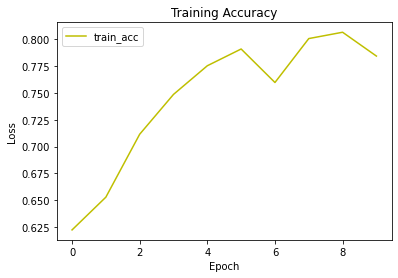

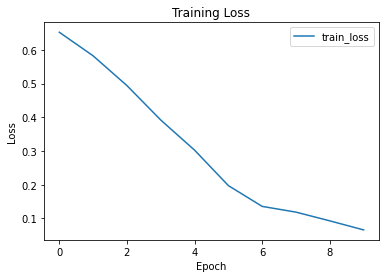

In [ ]:
plt.plot(dev_acc_values, label="train_acc", color='y')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
passages_val = val['passage'].values
questions_val = val['question'].values

input_ids_val, attention_masks_val = encode_data(tokenizer, questions_val, passages_val, max_seq_length)
val_features = (input_ids_val, attention_masks_val, val['target'].values.astype(int))

val_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in val_features]
val_dataset = TensorDataset(*val_features_tensors)
val_sampler = RandomSampler(val_dataset)

prediction_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  
  predictions.append(np.argmax(logits, axis=1).flatten())
  true_labels.append(label_ids.flatten())

In [ ]:
acc_bert_ft = accuracy_score(f(predictions), f(true_labels))
acc_bert_ft

0.6650426309378806

In [ ]:
df_3 = pd.DataFrame(np.array([acc_bert_ft]), index=['BERT_Fine_Tuning'], columns=['accuracy_BERT_Fine_Tuning'])
df_3

,accuracy_BERT_Fine_Tuning
BERT_Fine_Tuning,0.665043


### [10%] 4. Summary & results analysis


* 4.1    (5%) Compare the results of all the tested models and try to interpret them.

* 4.2    (5%) Propose, how you may improve the model score (write at least three ideas).



## Conclusion

In [ ]:
df_1.join(df_2).join(df_3, how='outer')

,accuracy_W2V_emb,accuracy_BERT_emb,accuracy_BERT_Fine_Tuning
BERT_Fine_Tuning,NaN,NaN,0.665043
ExtraTreesClassifier,0.616322,0.535932,NaN
RandomForestClassifier,0.578563,0.520097,NaN
SVC,0.589525,0.591961,NaN


Didn't achieve results from original Paper. Although general patterns are on the place.

Undoubtedly, more experiments with **hyper parameters** are needed (Batch Size, Epochs, Learning rate, Optimizer), since the training is time-consuming and computationally intensive.

**Cross-validation** stacking can be used. This can greatly increase the training time, but it’s possible to reduce the prediction variance and increase the accuracy by 0.5-2%.

We also need more techniques to eliminate the effects of **data imbalance**. For example finding an optimal predicted probability threshold for validation dataset as Paper advised. 

Also, for the **Russian language corpus**, more experiments are needed to improve the quality of tokenization and extract embeddings, as my results showed that tokenization by the proposed methods are rude enough.

